This script will take files and experiments names specified in the second cell and extract a list of barcodes and their frequencies. The flanking sequence for each file will also be specificed individually. Reads where the flanking sequence isn't found will be noted as well as barcodes with N bases in them.

It also produces histograms for barcodes and rarefaction curves


In [5]:
import numpy as np
import itertools
import math
import pandas as pd
import time
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
import csv


In [6]:
# This information has to be input manually
# File names, barcode flank sequences

SSFlank = 'GGTGGTGACC'
SDFlank = 'GGTGGTGACC'
DSFlank = 'GGGCGGCCGC'

# np113001Data = '/Volumes/NP_DFS_4TB/NPDFS01/NP-11-27-21_S1_L001_R1_001.fastq'


# listOfFiles = [np113001Data]
listOfFileNames = ['NP_11_30_1_1']
listOfLibTypes = ['SS']


In [31]:
# Parse and extract barcode, make csv files for each one

# def parseAndExtractBC(file, libtype):
#     BCFlank = ''
#     if libtype == 'SS':
#         BCFlank = SSFlank
#     if libtype == 'SD':
#         BCFlank = SDFlank
#     if libtype == 'DS':
#         BCFlank = DSFlank
#     parsedFile = SeqIO.parse(file, "fastq")
#     BClist = []
    
#     for readCount, rec in enumerate(parsedFile):
#         if readCount % 1000000 == 0:
#             print(readCount)
#         readSeq = str(rec.seq)
#         BCloc = readSeq.find(BCFlank)
#         if BCloc == -1:
#             BClist.append('No flank found')
#         else:
#             BC = readSeq[BCloc + len(BCFlank):BCloc + len(BCFlank) + 15]
#             if 'N' in BC:
#                 BClist.append('BC has Ns')
#             else:
#                 BClist.append(BC)
#     return BClist

# for i, file in enumerate(listOfFiles):
#     print(listOfFileNames[i])
#     dfBClist = pd.DataFrame(parseAndExtractBC(file, listOfLibTypes[i]), columns = [listOfFileNames[i]])
#     dfBClist.to_csv('/Volumes/NP_DFS_4TB/NPDFS01/' + listOfFileNames[i] + '_BClist.csv')



NP_11_27_21
0
1000000
2000000
NP_11_27_22
0
1000000
2000000
NP_11_27_26
0
1000000
2000000
NP_11_27_27
0
1000000
2000000
3000000
NP_11_27_29
0
1000000
2000000
NP_11_27_30
0
1000000
2000000


In [3]:
# Collapse down to smaller list with reads per barcode measured

# for i, file in enumerate(listOfFiles):
#     dfBCs = pd.read_csv(listOfFileNames[i] + '_BClist.csv')
#     dfBCCounts = dfBCs[listOfFileNames[i]].value_counts()
#     dfBCCounts.to_csv(listOfFileNames[i] + '_BCCounts.csv')

NameError: name 'listOfFiles' is not defined

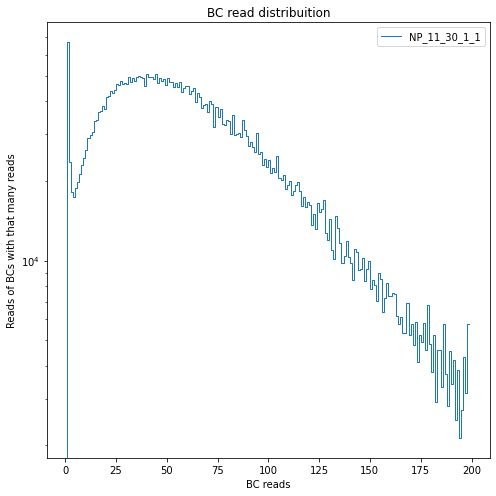

In [9]:
# What I really want is a graph where I multiply by the number of barcodes again 
# The y-axis should be "reads of BCs with that many reads"
# Multiply each bin by its x-axis value
# I had to move the values over by one to handle indexes and I had to trim a value from the x-axis values

# Ideally, the total # of reads divided by the maximum of this curve will be the library complexity
#  This approximation will likely improve if we exclude single-read barcodes


histData = []

for i, experiment in enumerate(listOfFileNames):
    dfData = pd.read_csv(listOfFileNames[i] + '_BCCounts.csv')
    data = np.histogram(dfData[listOfFileNames[i]], \
                 bins = range(0,200,1))
    histData.append(data)

for i, experiment in enumerate(listOfFileNames):
    xVals = histData[0][1][1:]
    yVals = histData[i][0]
    corrYVals = []
    for j, count in enumerate(yVals):
        corrYVals.append(count * (xVals[j] - 1))
    plt.step(xVals, corrYVals, label = listOfFileNames[i], linewidth = 1)

plt.yscale("log")
plt.legend()
plt.title('BC read distribuition')
plt.ylabel('Reads of BCs with that many reads')
plt.xlabel('BC reads')
plt.yscale('log')
plt.tight_layout()
plt.rcParams["figure.figsize"] = (7,7)

plt.savefig('NP_11_27_barcodesHist.pdf')


In [12]:
counts

,Unnamed: 0,NP_11_30_1_1
0,No flank found,62530
1,CATAGAATGCACTTC,1010
2,TGCGTTAGGCCTCGC,981
3,CATTGCAGCAAGAGT,694
4,GCGGGCACGGAGGCC,679
...,...,...
206292,AAGAACAGTACTAAA,1
206293,AGTCGTTGGGTTTGA,1
206294,GTATATGATCTCGAT,1
206295,TAATCTGTTAGTGTC,1


In [39]:
# Filter out barcodes with just one read
# Figure out how many reads had no flank or had N's in them
# Also figure out how many barcodes have just one read
# Make stacked plot

readFilterData = {}

for label in listOfFileNames:
    readFilterData[label] = {'No flank found' : [], \
                             'BC has Ns' : [], \
                             'Singleton BC' : [], \
                             'Filtered BCs' : []}

for i, experiment in enumerate(listOfFileNames):
    counts = pd.read_csv(experiment + '_BCCounts.csv', index_col = 0)
    readFilterData[experiment]['Singleton BC'] = counts[counts[experiment] == 1][experiment].sum()
    readFilterData[experiment]['No flank found'] = counts[counts.index == 'No flank found'][experiment].sum()
    readFilterData[experiment]['BC has Ns'] = counts[counts.index == 'BC has Ns'][listOfFileNames[i]].sum()
    readFilterData[experiment]['Filtered BCs'] = counts[(counts[experiment] > 1) & 
                                                        (counts[experiment] != 'No flank found') & \
                                                       (counts[experiment] != 'BC has Ns')][experiment].sum()
    



In [40]:
readFilterData

{'NP_11_30_1_1': {'No flank found': 62530,
  'BC has Ns': 217,
  'Singleton BC': 66858,
  'Filtered BCs': 4955920}}

In [41]:
dfStackedPlot = pd.DataFrame(readFilterData).transpose()
dfStackedPlot

,BC has Ns,Filtered BCs,No flank found,Singleton BC
NP_11_30_1_1,217,4955920,62530,66858


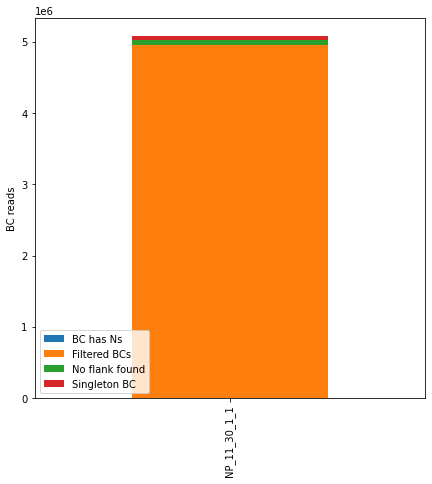

In [42]:
# Plot the data

dfStackedPlot = pd.DataFrame(readFilterData).transpose()

dfStackedPlot.plot(kind="bar", stacked=True)
plt.ylabel('BC reads')

plt.savefig('NP_11_30_readsSummary.pdf')


In [36]:
# Make one set of all barcodes, make a second set that only considers barcodes seen more than once

n = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
howOftenToSample = 100000
rarefactionData = {}
rarefactionDataFiltered = {}

for label in listOfFileNames:
    rarefactionData[label] = []
    rarefactionDataFiltered[label] = []

for i, experiment in enumerate(listOfFileNames):
    readsDF = pd.read_csv('/Volumes/NP_DFS_4TB/NPDFS01/' + listOfFileNames[i] + '_BClist.csv')
    counts = readsDF[experiment].value_counts()
    filteredCounts = counts[counts > 1]
    # sort_index() ensures that the barcodes aren't reordered
    filteredReadsDF = readsDF.merge(pd.DataFrame(filteredCounts), left_on = experiment, right_index = True).sort_index()
    for read in range(len(readsDF)):
        if read%300000 == 0:
            print(str((100 * read)/len(readsDF[experiment]))[:4] + '% done')
        if ((read % howOftenToSample) == 0 or (read in n)):
            unfilteredBCsUpToRead = readsDF[experiment][:read]
            rarefactionData[experiment].append([unfilteredBCsUpToRead.count(), unfilteredBCsUpToRead.nunique()])
            filteredBCsUpToRead = filteredReadsDF[experiment][:read]
            rarefactionDataFiltered[experiment].append([filteredBCsUpToRead.count(), filteredBCsUpToRead.nunique()])

# Transpose data

rarefactionDataTransposedUnfiltered = {}
rarefactionDataTransposedFiltered = {}
# Transpose values
for label in listOfFileNames:
    BCcounts, unique_BCs = list(map(list, zip(*rarefactionData[label])))
    rarefactionDataTransposedUnfiltered[label] = BCcounts, unique_BCs
    BCcounts, unique_BCs = list(map(list, zip(*rarefactionDataFiltered[label])))
    rarefactionDataTransposedFiltered[label] = BCcounts, unique_BCs



0.0% done
11.2% done
22.5% done
33.8% done
45.0% done
56.3% done
67.6% done
78.9% done
90.1% done
0.0% done
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.1% done
70.1% done
80.1% done
90.1% done
0.0% done
8.60% done
17.2% done
25.8% done
34.4% done
43.0% done
51.6% done
60.2% done
68.8% done
77.4% done
86.0% done
94.6% done
0.0% done
11.0% done
22.0% done
33.0% done
44.0% done
55.0% done
66.0% done
77.0% done
88.0% done
99.1% done
0.0% done
10.7% done
21.4% done
32.2% done
42.9% done
53.6% done
64.4% done
75.1% done
85.8% done
96.6% done


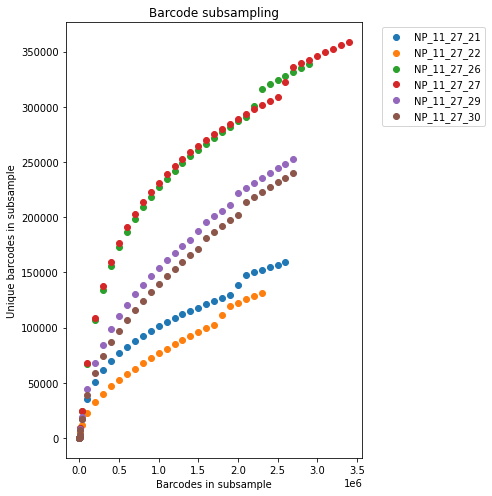

In [37]:
# Plot curves

for label in listOfFileNames:
    plt.scatter(rarefactionDataTransposedUnfiltered[label][0], rarefactionDataTransposedUnfiltered[label][1])

plt.legend(listOfFileNames, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Barcode subsampling')
plt.xlabel('Barcodes in subsample')
plt.ylabel('Unique barcodes in subsample')

plt.tight_layout()

plt.savefig('NP_11_27_rarefaction.pdf')

    

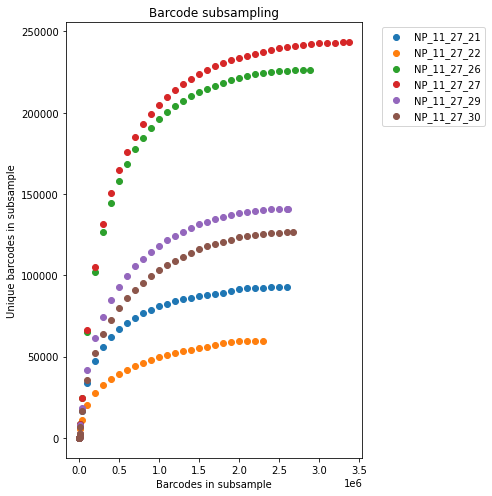

In [38]:
# Plot filtered curves

for label in listOfFileNames:
    plt.scatter(rarefactionDataTransposedFiltered[label][0], rarefactionDataTransposedFiltered[label][1])

plt.legend(listOfFileNames, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Barcode subsampling')
plt.xlabel('Barcodes in subsample')
plt.ylabel('Unique barcodes in subsample')

plt.tight_layout()

plt.savefig('NP_11_27_rarefactionFiltered.pdf')

In [39]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

now = 2021-04-07 16:59:32.594332
